In [1]:
# run CW ODMR.
# control the frequency changes "manually" with the code here instead of using external trigger

In [1]:
%matplotlib inline

In [2]:
import nidaqmx
import numpy as np
import qt3rfsynthcontrol
import ctypes
import nidaqmx._lib  # Due to NIDAQmx C-API bug needed to bypass property getter (according to qudi)
import nidaqmx.stream_readers
import time
import matplotlib.pyplot as plt
import qcsapphire


In [3]:
nisys = nidaqmx.system.System()
device = nidaqmx.system.Device('Dev1')

In [4]:
list(nisys.tasks)

[]

In [95]:
device.reset_device()

In [6]:
#list(nisys.devices)

In [7]:
#device = nidaqmx.system.Device('Dev1')
#list(device.ao_physical_chans)
# list(device.ai_physical_chans)
#list(device.di_lines)
#list(device.do_lines)
#list(device.co_physical_chans)
#list(device.ci_physical_chans)
# list(device.terminals)

In [116]:
#Configure the NI DAQ

def configure_tasks(post_fix_task_name = None, 
                    device_name = 'Dev1',
                    clock_counter = 'ctr1',
                    clock_di_line = 'port0',
                    edge_input_channel = 'PFI12',
                    edge_input_counter = 'ctr2',
                    clock_rate = 1000, 
                    N_data_samples_to_acquire = 500,
                    trigger_input = None,
                    new_edge_task = False,
                    new_clock_task = False,
                    continuous_daq = False):
   
    clock_task_name = f'sample_clock{post_fix_task_name}' 
    clock_task = nidaqmx.Task(clock_task_name)
       
    if new_clock_task:
        clock_task.di_channels.add_di_chan(f'{device_name}/{clock_di_line}')
        clock_task.timing.cfg_samp_clk_timing(clock_rate,
                                    sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS)
     
        clock_channel = f'/{device_name}/di/SampleClock'

    else:
        #this adds the clock signal to the output channel
        #is this necessary? 
        clock_task.co_channels.add_co_pulse_chan_freq(
                '/{0}/{1}'.format(device_name, clock_counter),
                freq=clock_rate,
                idle_state=nidaqmx.constants.Level.LOW)

        # clock_task.timing.cfg_implicit_timing(
        #     sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
        #     samps_per_chan=n_steps+2) #qudi configures with n_steps + 1, should recheck why. suspicious extra "1" floating around (n_steps = 101)

        clock_task.timing.cfg_implicit_timing(
            sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,
            samps_per_chan=clock_rate) #qudi configures with n_steps + 1, should recheck why. suspicious extra "1" floating around (n_steps = 101)

        clock_channel = '/{0}InternalOutput'.format(clock_task.channel_names[0])

    edge_detector_task_name = f'edge_input{post_fix_task_name}'

    edge_detector_task = nidaqmx.Task(edge_detector_task_name)

    #todo -- try to replace all of this with edge_detector_task.add_ci_count_edges_chan
    
    

    ctr_name = f'/{device_name}/{edge_input_counter}'
    chnl_name = f'/{device_name}/{edge_input_channel}'
    
    if new_edge_task: #following nspyre recipe
        edge_detector_task.ci_channels.add_ci_count_edges_chan(
                                    ctr_name,
                                    edge=nidaqmx.constants.Edge.RISING,
                                    initial_count=0,
                                    count_direction=nidaqmx.constants.CountDirection.COUNT_UP)
        edge_detector_task.ci_channels.all.ci_count_edges_term = chnl_name
        
        if continuous_daq:
            edge_detector_task.timing.cfg_samp_clk_timing(clock_rate, 
                                                          source=clock_channel,
                                                          active_edge=nidaqmx.constants.Edge.RISING, 
                                                          sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS)    
        else:        
            edge_detector_task.timing.cfg_samp_clk_timing(clock_rate, 
                                                          source=clock_channel,
                                                          active_edge=nidaqmx.constants.Edge.RISING, 
                                                          sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                                                          samps_per_chan=N_data_samples_to_acquire)
        
    else:
        # why does qudi count the period of signal? In units of "ticks" -- is that the same as edge counting? 
        
        edge_detector_task.ci_channels.add_ci_period_chan(
                            ctr_name,
                            min_val=0,
                            max_val=100000000,
                            units=nidaqmx.constants.TimeUnits.TICKS,
                            edge=nidaqmx.constants.Edge.RISING)
        # I get no data when I swap out the line above for this line
        # edge_detector_task.ci_channels.add_ci_count_edges_chan(
        #                             ctr_name,
        #                             edge=nidaqmx.constants.Edge.RISING,
        #                             initial_count=0,
        #                             count_direction=nidaqmx.constants.CountDirection.COUNT_UP)
        
        # from qudi -- apparently this overcomes some kind of bug in the C-library, according to comments in qudi code
        try:
            # this sets the counter to read from the appropriate terminal
            nidaqmx._lib.lib_importer.windll.DAQmxSetCIPeriodTerm(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(clock_channel.encode('ascii')))
            
            #this tells the counter which clock to use
            nidaqmx._lib.lib_importer.windll.DAQmxSetCICtrTimebaseSrc(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(chnl_name.encode('ascii')))
        except:
            nidaqmx._lib.lib_importer.cdll.DAQmxSetCIPeriodTerm(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(clock_channel.encode('ascii')))
            nidaqmx._lib.lib_importer.cdll.DAQmxSetCICtrTimebaseSrc(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(chnl_name.encode('ascii')))

        edge_detector_task.timing.cfg_implicit_timing(sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                                                      samps_per_chan=N_data_samples_to_acquire)
    
    if trigger_input:
        edge_detector_task.triggers.arm_start_trigger.trig_type =  nidaqmx.constants.TriggerType.DIGITAL_EDGE
        edge_detector_task.triggers.arm_start_trigger.dig_edge_edge =  nidaqmx.constants.Edge.RISING
        edge_detector_task.triggers.arm_start_trigger.dig_edge_src = f'/{device_name}/{trigger_input}'
    

    edge_detector_reader = nidaqmx.stream_readers.CounterReader(edge_detector_task.in_stream)
    
    return clock_task, edge_detector_task, edge_detector_reader



In [117]:
def run_once(detector_task, detector_reader, clock_rate,  N_samples,  read_write_timeout=10, pulser = None):
    
    detector_task.wait_until_done() #this doesn't seem to always work
    detector_task.start()
    data_buffer = np.zeros(N_samples)
    
    if pulser:
        pulser.software_trigger()
    
    time.sleep(N_samples / clock_rate * 1.1)
    read_samples = detector_reader.read_many_sample_double(
                            data_buffer,
                            number_of_samples_per_channel=N_samples,
                            timeout=read_write_timeout)
    detector_task.stop()
    try:
        assert read_samples == N_samples
    except Exception as e:
        print(e)
        print(f'{read_samples} != {N_samples}')
        raise e
        
    return data_buffer

In [10]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [11]:
rfsynth.hw_info()

[('model_type', 'WFT SynthHD 1694'),
 ('serial_number', 1694),
 ('fw_version', 'Firmware Version 3.23'),
 ('hw_version', 'Hardware Version 2.06'),
 ('sub_version', 'HD')]

In [12]:
qcsapphire.discover_devices()

[['COM3',
  'Intel(R) Active Management Technology - SOL (COM3)',
  'PCI\\VEN_8086&DEV_43E3&SUBSYS_0A541028&REV_11\\3&11583659&1&B3'],
 ['COM5',
  'USB Serial Device (COM5)',
  'USB VID:PID=0483:A3E5 SER=206A36705430 LOCATION=1-2:x.0'],
 ['COM7',
  'USB Serial Device (COM7)',
  'USB VID:PID=239A:8014 SER=3B0D07C25831555020312E341A3214FF LOCATION=1-6:x.0']]

In [13]:
p = qcsapphire.Pulser('COM6')

SerialException: could not open port 'COM6': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)

In [72]:
p.set_all_state_off()

NameError: name 'p' is not defined

In [40]:
## set up for software trigger pulses on channel B
p.pulse0.mode('single')
p.pulse0.period(0.0001) # 100 mus period
p.pulse0.external.mode('trigger')
p.pulse2.cmode('single')
p.pulse2.polarity('normal')
p.pulse2.width(0.000001) # 1 mus wide pulse

'ok'

In [124]:

def run_with_options(freq_low, freq_high, freq_step,
                     N_samples_per_step, clock_rate, 
                     trigger_input, pulser, rfsynth, 
                     use_new_edge_task, new_clock_task, 
                     continuous_daq, normalize, rf_power,
                     cooling_time = 0):


    data = None


    try:
        daq_time = N_samples_per_step / clock_rate
        print(f'acquiring {daq_time} seconds of data per sample')

        clock_task, edge_detector_task, edge_detector_reader = configure_tasks(post_fix_task_name = 'v162', 
                                                                                clock_rate = clock_rate, 
                                                                                N_data_samples_to_acquire = N_samples_per_step,
                                                                                edge_input_channel = 'PFI12',
                                                                                clock_counter = 'ctr1',
                                                                                trigger_input = trigger_input,
                                                                                new_edge_task = use_new_edge_task,
                                                                                new_clock_task = new_clock_task,
                                                                                continuous_daq = continuous_daq)

        if clock_task:
            clock_task.start()

        data = {}
        
        current_freq = freq_low
        step = 0

        if pulser:
            pulser.pulse0.state(1)
            pulser.pulse2.state(1)

        if rfsynth:
            rfsynth.rf_off(0)
            
        while current_freq < freq_high:
            if rfsynth:
                rfsynth.set_channel_fixed_output(0, rf_power, current_freq)
          
            if normalize:
                normalized_count_rate_pre = run_once(edge_detector_task, edge_detector_reader, clock_rate, N_samples_per_step, read_write_timeout = 10, pulser = pulser)
          
            if rfsynth:
                rfsynth.rf_on(0)
            data_at_one_freq = run_once(edge_detector_task, edge_detector_reader, clock_rate, N_samples_per_step, read_write_timeout = 10, pulser = pulser)
            if rfsynth:
                rfsynth.rf_off(0)
                
            if normalize:
                normalized_count_rate_post = run_once(edge_detector_task, edge_detector_reader, clock_rate, N_samples_per_step, read_write_timeout = 10, pulser = pulser)
                normalized_count_rate = np.mean([normalized_count_rate_pre,normalized_count_rate_post])
                data[current_freq] = data_at_one_freq.mean() / normalized_count_rate
            else:
                data[current_freq] = data_at_one_freq.mean() * clock_rate
                
            if step % 10 == 0:
                if normalize:
                    print(f'{current_freq/1e9} GHz: {data[current_freq]} normalized intensity')
                else:
                    print(f'{current_freq/1e9} GHz: {data[current_freq]} mean counts/second')
            current_freq += freq_step
            step += 1
            
            time.sleep(cooling_time)
            
    except Exception as e:
        raise(e)

    finally:

        try:
            if rfsynth:
                rfsynth.rf_off(0)
            if pulser:
                pulser.pulse0.state(0)
                pulser.pulse2.state(0)
        except Exception as e:
            print(e)

        try:
            if clock_task:
                clock_task.stop()
        except Exception as e:
            print(e)

        try:
            if clock_task:
                clock_task.close()
        except Exception as e:
            print(e)

        try:
            if edge_detector_task:
                edge_detector_task.close()
        except Exception as e:
            print(e)
            
        return data

In [104]:
# freq_low = 2820e6
# freq_high = 3130e6
# freq_step = 10e6

# # pulsed, triggered
# # N = 2
# # clock_rate = int(400e3) #400 kHz -- N = 2 samples, this is a 5 mu second window of data acquisition, equal to pulsed ODMR
# # N = 8
# # clock_rate = int(1600e3)
# # trigger_input = 'PFI0'
# # pulser = p

# # cw odmr


# N = 50
# clock_rate = int(200)
# # trigger_input = 'PFI0'
# # pulser = p
# # trigger_input = None
# # pulser = None


#qudi style, ODMR
freq_low = 2820e6
freq_high = 2930e6
freq_step = 1e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
rf = rfsynth
use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = True
rf_power = -20

data_qudi_style = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)

acquiring 0.25 seconds of data per sample
2.82 GHz: 199.9407157789635 normalized intensity
2.83 GHz: 200.07852990316422 normalized intensity
2.84 GHz: 200.03133629205 normalized intensity
2.85 GHz: 200.21052184956463 normalized intensity
2.86 GHz: 199.7160917550696 normalized intensity
2.87 GHz: 195.85349378776024 normalized intensity
2.88 GHz: 199.68935262520063 normalized intensity
2.89 GHz: 200.00893221917434 normalized intensity
2.9 GHz: 200.04388332677937 normalized intensity
2.91 GHz: 199.92817001097956 normalized intensity
2.92 GHz: 200.00183632898978 normalized intensity


acquiring 0.25 seconds of data per sample
2.82 GHz: 0.999135611349725 normalized intensity
2.83 GHz: 1.0000853665505633 normalized intensity
2.84 GHz: 0.9996737747778617 normalized intensity
2.85 GHz: 0.9992881466712611 normalized intensity
2.86 GHz: 0.9988587328877047 normalized intensity
2.87 GHz: 0.9827949191412866 normalized intensity
2.88 GHz: 0.9983675212225724 normalized intensity
2.89 GHz: 0.9995214695634946 normalized intensity
2.9 GHz: 1.0002314460853043 normalized intensity
2.91 GHz: 1.0015006895684742 normalized intensity
2.92 GHz: 0.9993554199608097 normalized intensity


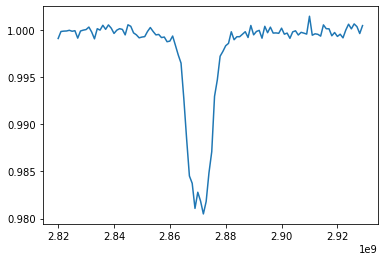

In [107]:
freq_low = 2820e6
freq_high = 2930e6
freq_step = 1e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
rf = rfsynth
use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = True
rf_power = -20

data_qudi_style = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)
plt.plot(data_qudi_style.keys(), data_qudi_style.values())

acquiring 0.25 seconds of data per sample
2.82 GHz: 0.9999526028552221 normalized intensity
2.83 GHz: 1.0002205678619864 normalized intensity
2.84 GHz: 0.9994168144761277 normalized intensity
2.85 GHz: 1.000265402031681 normalized intensity
2.86 GHz: 0.9995172137637307 normalized intensity
2.87 GHz: 0.9956521847902203 normalized intensity
2.88 GHz: 0.999181760151651 normalized intensity
2.89 GHz: 1.0001665706382386 normalized intensity
2.9 GHz: 0.9996963846576686 normalized intensity
2.91 GHz: 0.9996615302882593 normalized intensity
2.92 GHz: 1.0002448202095897 normalized intensity


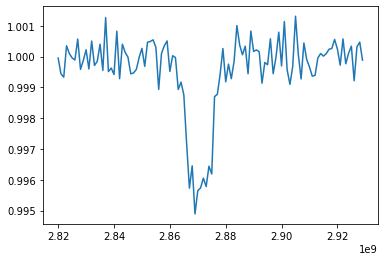

In [108]:
freq_low = 2820e6
freq_high = 2930e6
freq_step = 1e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
rf = rfsynth
use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = True
rf_power = -30

data_qudi_style = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)
plt.plot(data_qudi_style.keys(), data_qudi_style.values())

acquiring 0.25 seconds of data per sample
2.82 GHz: 0.9995914018122531 normalized intensity
2.83 GHz: 0.9996012887921844 normalized intensity
2.84 GHz: 0.9989874533053856 normalized intensity
2.85 GHz: 0.9990211156071869 normalized intensity
2.86 GHz: 0.9943302102760815 normalized intensity
2.87 GHz: 0.9684854915238071 normalized intensity
2.88 GHz: 0.9928863213074145 normalized intensity
2.89 GHz: 0.9983895819325384 normalized intensity
2.9 GHz: 0.998783478125177 normalized intensity
2.91 GHz: 0.9992112035262438 normalized intensity
2.92 GHz: 0.9994368247590976 normalized intensity


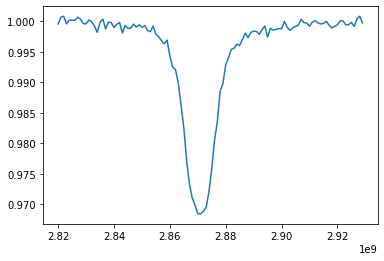

In [109]:
freq_low = 2820e6
freq_high = 2930e6
freq_step = 1e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
rf = rfsynth
use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = True
rf_power = -10

data_qudi_style = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)
plt.plot(data_qudi_style.keys(), data_qudi_style.values())

acquiring 0.25 seconds of data per sample
2.82 GHz: 1.0006933008990697 normalized intensity
2.83 GHz: 0.9990490261323169 normalized intensity
2.84 GHz: 0.9994846377216854 normalized intensity
2.85 GHz: 0.9992163003928746 normalized intensity
2.86 GHz: 0.9937318569099804 normalized intensity
2.87 GHz: 0.9662696762169322 normalized intensity
2.88 GHz: 0.991326631600276 normalized intensity
2.89 GHz: 0.9972049631811039 normalized intensity
2.9 GHz: 0.9991793412846045 normalized intensity
2.91 GHz: 1.0008185716162428 normalized intensity
2.92 GHz: 0.999448679238624 normalized intensity


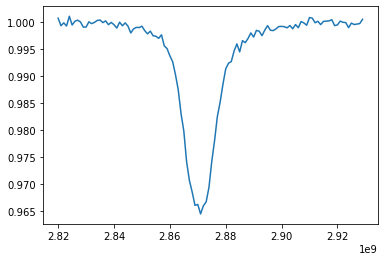

In [110]:
freq_low = 2820e6
freq_high = 2930e6
freq_step = 1e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
rf = rfsynth
use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = True
rf_power = -5

data_qudi_style = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)
plt.plot(data_qudi_style.keys(), data_qudi_style.values())

acquiring 0.25 seconds of data per sample
2.84 GHz: 0.9985843767302541 normalized intensity
2.845 GHz: 0.9841666537576442 normalized intensity
2.85 GHz: 0.9858704755145494 normalized intensity
2.855 GHz: 1.0027254113414037 normalized intensity
2.86 GHz: 1.004024579115412 normalized intensity
2.865 GHz: 1.0081393554801052 normalized intensity
2.87 GHz: 0.9826230620861989 normalized intensity
2.875 GHz: 0.9756542455229551 normalized intensity
2.88 GHz: 1.002351885092961 normalized intensity
2.885 GHz: 1.0109112466865173 normalized intensity
2.89 GHz: 0.9898730391040947 normalized intensity
2.895 GHz: 0.9903297696085489 normalized intensity


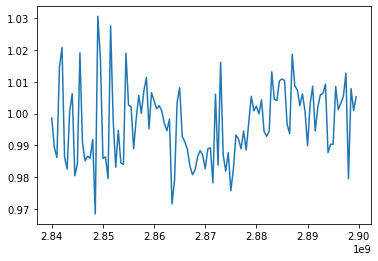

In [120]:
freq_low = 2850e6
freq_high = 2890e6
freq_step = 0.5e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
rf = rfsynth
use_new_edge_task = True
new_clock_task = False
continuous_daq = False
normalize = True
rf_power = -20

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)
plt.plot(data.keys(), data.values())

acquiring 0.25 seconds of data per sample
2.84 GHz: 1.0003284981691554 normalized intensity
2.845 GHz: 0.9999808089479973 normalized intensity
2.85 GHz: 0.9981257196886939 normalized intensity
2.855 GHz: 0.9987726091717902 normalized intensity
2.86 GHz: 0.9989357292301448 normalized intensity
2.865 GHz: 0.9891808849508121 normalized intensity
2.87 GHz: 0.9750534142806628 normalized intensity
2.875 GHz: 0.9815109115955731 normalized intensity
2.88 GHz: 0.9973860539914954 normalized intensity
2.885 GHz: 1.0006086379937857 normalized intensity
2.89 GHz: 0.9986404755953459 normalized intensity
2.895 GHz: 0.999368570865392 normalized intensity


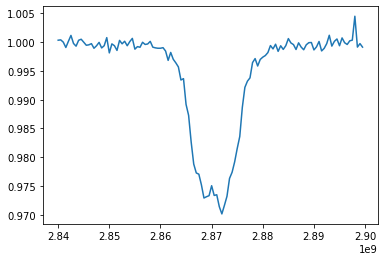

In [112]:
freq_low = 2840e6
freq_high = 2900e6
freq_step = 0.5e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
rf = rfsynth
use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = True
rf_power = -20

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)
plt.plot(data.keys(), data.values())

acquiring 0.25 seconds of data per sample
2.856 GHz: 0.9992711344411145 normalized intensity
2.858 GHz: 0.9993635852616731 normalized intensity
2.86 GHz: 0.9971590040690973 normalized intensity
2.862 GHz: 0.9960539238054504 normalized intensity
2.864 GHz: 0.9940713144802903 normalized intensity
2.866 GHz: 0.9777899491588278 normalized intensity
2.868 GHz: 0.9698644014454657 normalized intensity
2.87 GHz: 0.9695426427378059 normalized intensity
2.872 GHz: 0.9651619633269899 normalized intensity
2.874 GHz: 0.9747133609964841 normalized intensity
2.876 GHz: 0.9841102260221912 normalized intensity
2.878 GHz: 0.9943942093519625 normalized intensity
2.88 GHz: 0.9964152538740586 normalized intensity
2.882 GHz: 0.9987036317469238 normalized intensity


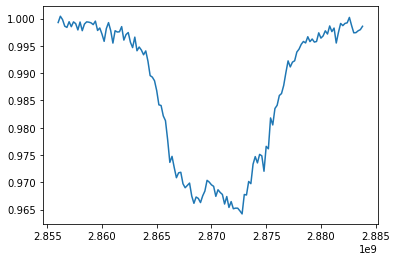

In [121]:
freq_low = 2856e6
freq_high = 2884e6
freq_step = 0.2e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
rf = rfsynth
use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = True
rf_power = -20

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)
plt.plot(data.keys(), data.values())

acquiring 0.25 seconds of data per sample
2.862 GHz: 0.9971767368777377 normalized intensity
2.8625 GHz: 0.995283621177767 normalized intensity
2.863 GHz: 0.9937665259218055 normalized intensity
2.8635 GHz: 0.9932416544281447 normalized intensity
2.864 GHz: 0.9923102449965099 normalized intensity
2.8645 GHz: 0.9885292432003705 normalized intensity
2.865 GHz: 0.9878466180137065 normalized intensity
2.8655 GHz: 0.98382122340386 normalized intensity
2.866 GHz: 0.977753768354079 normalized intensity
2.8665 GHz: 0.9740013392270808 normalized intensity
2.867 GHz: 0.9717162904975492 normalized intensity
2.8675 GHz: 0.9699551626020048 normalized intensity
2.868 GHz: 0.9678403785793188 normalized intensity
2.8685 GHz: 0.966856573845277 normalized intensity
2.869 GHz: 0.964929612110916 normalized intensity
2.8695 GHz: 0.9684815607143058 normalized intensity
2.87 GHz: 0.9669856505903579 normalized intensity
2.8705 GHz: 0.9694547722643257 normalized intensity
2.871 GHz: 0.9662005735872293 normaliz

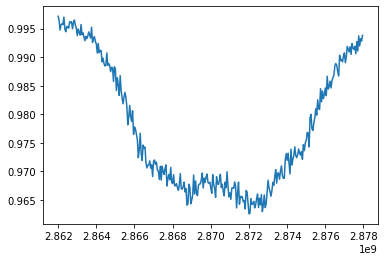

In [122]:
freq_low = 2862e6
freq_high = 2878e6
freq_step = 0.05e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
rf = rfsynth
use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = True
rf_power = -20

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)
plt.plot(data.keys(), data.values())

acquiring 0.25 seconds of data per sample
2.862 GHz: 0.9960062660780683 normalized intensity
2.8625 GHz: 0.9963187171627186 normalized intensity
2.863 GHz: 0.9934965225101535 normalized intensity
2.8635 GHz: 0.9923481463521643 normalized intensity
2.864 GHz: 0.9917571563070533 normalized intensity
2.8645 GHz: 0.9883253483121318 normalized intensity
2.865 GHz: 0.9868054031556245 normalized intensity
2.8655 GHz: 0.9833754757412461 normalized intensity
2.866 GHz: 0.9770704525177266 normalized intensity
2.8665 GHz: 0.9761446882781039 normalized intensity
2.867 GHz: 0.9732716873754329 normalized intensity
2.8675 GHz: 0.9705020781338924 normalized intensity
2.868 GHz: 0.9704873864184315 normalized intensity
2.8685 GHz: 0.9668650142586998 normalized intensity
2.869 GHz: 0.971019106088345 normalized intensity
2.8695 GHz: 0.9724920049029651 normalized intensity
2.87 GHz: 0.9717795382522048 normalized intensity
2.8705 GHz: 0.972472826427519 normalized intensity
2.871 GHz: 0.9736886271329285 norm

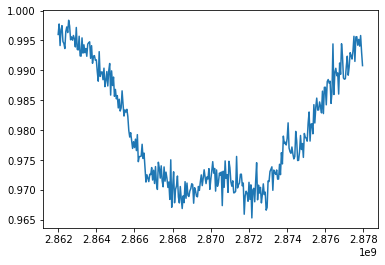

In [126]:
freq_low = 2862e6
freq_high = 2878e6
freq_step = 0.05e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
rf = rfsynth
use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = True
rf_power = -20
cooling_time = 1.0 #rest (in seconds) between freq steps to cool off 

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power, cooling_time)
plt.plot(data.keys(), data.values())

acquiring 0.25 seconds of data per sample
2.84 GHz: 0.9990269721545586 normalized intensity
2.85 GHz: 1.0010020650290377 normalized intensity
2.86 GHz: 1.0005136999657904 normalized intensity
2.87 GHz: 0.9772993997167204 normalized intensity
2.88 GHz: 0.9966144507780694 normalized intensity
2.89 GHz: 1.0034733392708584 normalized intensity


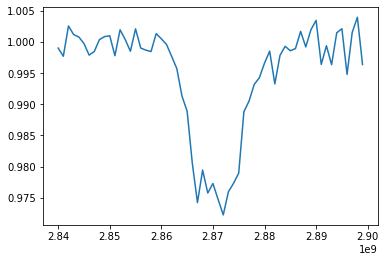

In [128]:
freq_low = 2840e6
freq_high = 2900e6
freq_step = 1e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
rf = rfsynth
use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = True
rf_power = -20

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)
plt.plot(data.keys(), data.values())

acquiring 0.25 seconds of data per sample
2.8 GHz: 1.00140560361038 normalized intensity
2.81 GHz: 0.9986373286414034 normalized intensity
2.82 GHz: 0.9982804007393205 normalized intensity
2.83 GHz: 0.9980713479943233 normalized intensity
2.84 GHz: 0.9962411660135533 normalized intensity
2.85 GHz: 1.0022956297604417 normalized intensity
2.86 GHz: 0.9957385891963091 normalized intensity
2.87 GHz: 0.9848938515088334 normalized intensity
2.88 GHz: 0.9914508008251 normalized intensity
2.89 GHz: 0.9979580194653069 normalized intensity
2.9 GHz: 1.002147934807377 normalized intensity
2.91 GHz: 1.0020850080072783 normalized intensity


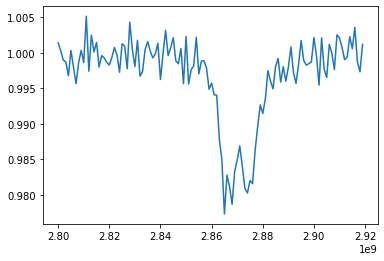

In [129]:
#placing magnet nearby

freq_low = 2800e6
freq_high = 2920e6
freq_step = 1e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
rf = rfsynth
use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = True
rf_power = -20

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)
plt.plot(data.keys(), data.values())

acquiring 1.0 seconds of data per sample
2.855 GHz: 0.9999667234056713 normalized intensity
2.8575 GHz: 0.9951159571093581 normalized intensity
2.86 GHz: 0.9956391348914504 normalized intensity
2.8625 GHz: 0.9897571464424009 normalized intensity
2.865 GHz: 0.9661325625704271 normalized intensity
2.8675 GHz: 0.9600724374694078 normalized intensity
2.87 GHz: 0.9670244966565329 normalized intensity
2.8725 GHz: 0.9568584126769946 normalized intensity
2.875 GHz: 0.9636062285617952 normalized intensity
2.8775 GHz: 0.9802371715494507 normalized intensity
2.88 GHz: 0.9919241968508989 normalized intensity
2.8825 GHz: 0.997420416269332 normalized intensity


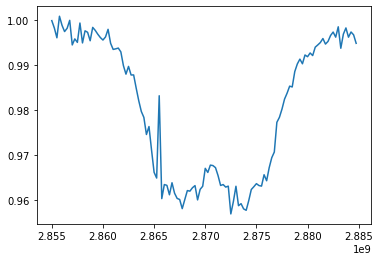

In [132]:
#placing magnet nearby

freq_low = 2855e6
freq_high = 2885e6
freq_step = .25e6
N = 200
clock_rate = 200 #Hz
trigger_input = None
pulser = None
rf = rfsynth
use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = True
rf_power = -20

data = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)
plt.plot(data.keys(), data.values())